In [1]:
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import Sigmoid
from torch.nn import LogSoftmax
from torch import flatten
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.metrics import classification_report

DIRECTORY = 'data'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 1 Carga de Datos
El profesor le provee el conjunto de datos y un código de carga que le permitirá cargar los datos de entrenamiento y prueba a la memoria 

In [2]:
def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8')
             for n in unpickle(DIRECTORY + "/batches.meta")[b'label_names']]
    x_train = None
    y_train = []

    for i in range(1, 6):
        data = unpickle(DIRECTORY + "/data_batch_" + str(i))
        if i > 1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']

    data = unpickle(DIRECTORY + "/test_batch")

    x_test = data[b'data']
    y_test = data[b'labels']

    return names, x_train, y_train, x_test, y_test


## 2 Clase para crear dataset

In [3]:
class Dset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [4]:
def plot_tensor(tensor, perm=None):
    if perm == None:
        perm = (1, 2, 0)
    plt.figure()
    plt.imshow(tensor.permute(perm).cpu().numpy().astype(np.uint8))
    plt.show()


In [5]:
names, x_train, y_train, x_test, y_test = load_data()
names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
x_train_tensors = torch.tensor(x_train).to(DEVICE)
y_train_tensors = torch.tensor(y_train).to(DEVICE)
x_train_tensors = torch.reshape(x_train_tensors, [50000, 3, 32, 32])
x_test_tensors = torch.tensor(x_train).to(DEVICE)
y_test_tensors = torch.tensor(y_train).to(DEVICE)
x_test_tensors = torch.reshape(x_test_tensors, [50000, 3, 32, 32])

x_test_tensors.shape


torch.Size([50000, 3, 32, 32])

## 3 Red Convolusional  
Deberá construir su red neuronal usando la biblioteca Torch según lo visto en clase. Dado que trabajaremos con imágenes no es recomendable usar capas densas hasta haber disminuido la complejidad del problema utilizando capas convolucionales.

In [7]:
def get_max(output):
  return torch.argmax(output, dim=1)

class Net(Module):
  def __init__(self, num_channels, classes) -> None:
    super(Net, self).__init__()
    
    self.losses = []

    # first set | conv_layer -> relu -> pool
    self.conv1 = Conv2d(in_channels=num_channels, out_channels=6, kernel_size=(5, 5), padding='same')
    self.sig1 = Sigmoid()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # second set | conv -> relu -> pool
    self.conv2 = Conv2d(in_channels=6, out_channels=9, kernel_size=(3, 3), padding='same')
    self.sig2 = Sigmoid()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initializa fully connected layer
    self.fc1 = Linear(in_features=576, out_features=1000)
    self.sig3 = Sigmoid()

    # initialize softmax classifier
    self.fc2 = Linear(in_features=1000, out_features=classes)
    self.log_soft_max = LogSoftmax(dim=1)

  def forward(self, x):
    # the x data passes through our first set 
    # conv -> relu -> pool layers
    x = self.conv1(x)
    x = self.sig1(x)
    x = self.maxpool1(x)

    # passes the output from previous layer to through the second

    x = self.conv2(x)
    x = self.sig2(x)
    x = self.maxpool2(x)

    # flatten the output and passes it
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.sig3(x)

    # pass the output to our softmax to get our final output
    x = self.fc2(x)
    return self.log_soft_max(x)

In [8]:
net = Net(num_channels=3, classes=10)
net.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=1e-9)

In [9]:
classes, X_train, y_train, X_test, y_test = load_data()

X_train = np.resize(X_train, (50000, 3, 32, 32))
X_train = torch.tensor(data=X_train, dtype=torch.float, device=DEVICE)
y_train = torch.tensor(data=y_train, dtype=torch.float, device=DEVICE)
    
train_dset = Dset(X_train, y_train)
train_loader = DataLoader(dataset= train_dset, batch_size=100, shuffle=False)

test_dset = Dset(X_test, y_test)
test_loader = DataLoader(dataset= train_dset, batch_size=100, shuffle=False)

In [10]:

loss_val = 0.0

for e in range(500):
  for i, (inputs, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    net.train()
    y_pred = net(inputs)
    labels = labels.type(torch.LongTensor)
    loss = criterion(y_pred, labels.cuda())
    loss.backward()
    optimizer.step()
    net.losses.append(loss.item())


## 4 Perdida en entrenamiento

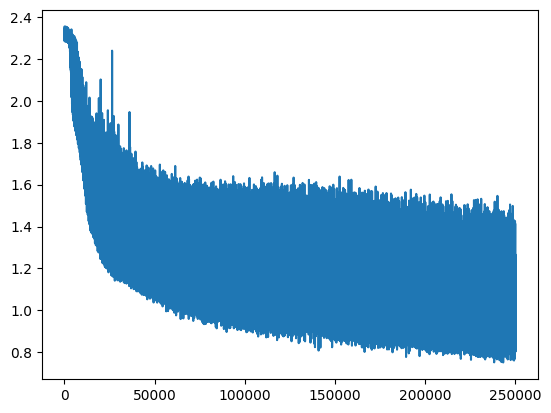

In [11]:
plt.plot(net.losses)
plt.show()

In [12]:
torch.cuda.empty_cache()
y_pred_train = net(x_test_tensors.float())


## 5 Matriz de Confusion

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


y_true = y_train_tensors.cpu().detach().numpy()
y_pred = get_max(y_pred_train).cpu().detach().numpy()

cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[3351,  215,  171,  123,  119,   46,   56,  114,  544,  261],
       [  98, 4093,   22,   53,   16,   23,   64,   58,  138,  435],
       [ 388,   98, 1860,  458,  650,  447,  491,  357,  163,   88],
       [  82,  111,  205, 2353,  294,  827,  421,  399,  111,  197],
       [ 154,   72,  248,  355, 2699,  270,  449,  581,  106,   66],
       [  22,   63,  174,  984,  321, 2521,  241,  526,   51,   97],
       [  43,  112,  152,  334,  259,  133, 3759,   89,   45,   74],
       [  52,   57,   78,  283,  282,  355,   81, 3608,   47,  157],
       [ 359,  302,   57,  102,   46,   28,   48,   46, 3816,  196],
       [ 161,  748,   26,  142,   22,   44,   66,  138,  136, 3517]],
      dtype=int64)

## 6 Reporte de Clasificación con entrenamiento

In [14]:
print(classification_report(y_true, y_pred, target_names=names))

              precision    recall  f1-score   support

    airplane       0.71      0.67      0.69      5000
  automobile       0.70      0.82      0.75      5000
        bird       0.62      0.37      0.47      5000
         cat       0.45      0.47      0.46      5000
        deer       0.57      0.54      0.56      5000
         dog       0.54      0.50      0.52      5000
        frog       0.66      0.75      0.70      5000
       horse       0.61      0.72      0.66      5000
        ship       0.74      0.76      0.75      5000
       truck       0.69      0.70      0.70      5000

    accuracy                           0.63     50000
   macro avg       0.63      0.63      0.63     50000
weighted avg       0.63      0.63      0.63     50000



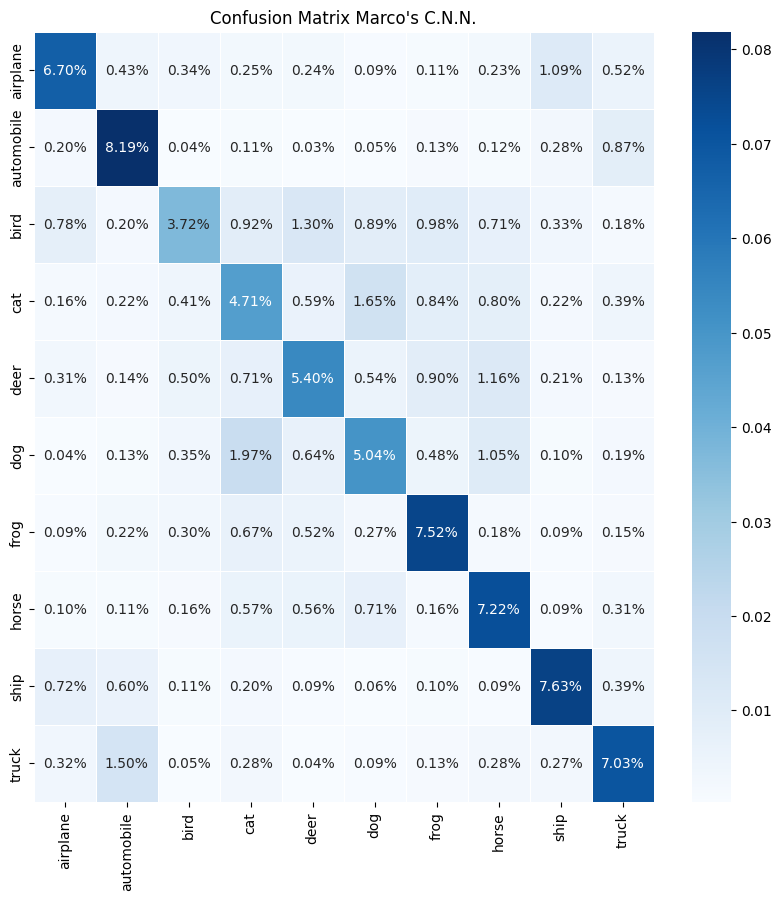

In [15]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  xticklabels=names, yticklabels=names, fmt='.2%', cmap='Blues', linewidths=.5, ax=ax)
ax.set_title('Confusion Matrix Marco\'s C.N.N.')
plt.show()

## 8 Cuáles categorías confunde su red? ¿Por qué cree que esas categorías le generan confusión/errores de clasificación?
> Al analizar la matriz de confusión y el mismo reporte, podemos ver que la red neuronal tiende a confundir más las categorias de gatos y pájaros. Esto puede ser por la naturaleza de las imagenes y que pueden poseer rasgos similares.